# Convert effective radiative forcings from RCMIP model output (csv/xlsx) to xarray Dataset:

## Imports:

In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import tqdm

In [2]:
import xarray as xr
import os
from IPython.display import clear_output
from scmdata import df_append, ScmDataFrame

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [3]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR

%load_ext autoreload
%autoreload 2

SAVEPATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models_quant.nc'

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in


In [4]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [5]:
# variables to load:
variables_erf = [
    'Effective Radiative Forcing|Anthropogenic|*',
    'Effective Radiative Forcing|Anthropogenic',
    'Effective Radiative Forcing',
    'Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Deposition of Black Carbon on Snow'
]
# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']

### Models to look for

Models are chosen solely on availability of relevant  data:

In [6]:

model_of_interest = [
    #    ".*acc2.*v2-0-1.*",
    ".*rcmip-phase-1_cicero-scm.*",
    #    ".*escimo.*v2-0-1.*",
    ".*fair-1.5-default.*",
    ".*fair-1.5-ens.*",
    #    ".*rcmip_phase-1_gir.*",
    #    ".*greb.*v2-0-0.*",
    #    ".*hector.*v2-0-0.*",
    #    ".*MAGICC7.1.0aX-rcmip-phase-1.*",
    ".*rcmip-phase-1_magicc7.1.0.beta*",
    ".*rcmip_phase-1_magicc7.1.0.beta.*",
    #    ".*MAGICC7.1.0aX.*",
    #    ".*mce.*v2-0-1.*",
    #    ".*oscar-v3-0*v1-0-1.*",
    ".*oscarv3.0.*"
    #    ".*wasp.*v1-0-1.*",
]

Where to look for files:

In [7]:

# RESULTS_PATH = os.path.join(BASE_DIR, "data", "results", "phase-1/")
RESULTS_PATH = os.path.join(INPUT_DATA_DIR, "database-results", "phase-1")
RESULTS_PATH
# RESULTS_PATH

'/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1'

In [8]:
SCENARIO_PROTOCOL = os.path.join(INPUT_DATA_DIR, "data", "protocol", "rcmip-emissions-annual-means-v3-1-0.csv")
SCENARIO_PROTOCOL

'/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/data/protocol/rcmip-emissions-annual-means-v3-1-0.csv'

List of files:

In [9]:
results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(Path(RESULTS_PATH).rglob("*.xlsx"))
results_files[:4]

[PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc32.csv'),
 PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-canesm5-r10i1p1f1_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv'),
 PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-canesm5-r1i1p2f1_world_radiative-forcing-anthropogenic-montreal-gases-ch2cl2.csv'),
 PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-noresm2-lm-r1i1p1f1_world_emissions-montreal-gases-cfc-cfc12.csv')]

## Make file list to load:

In [10]:
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print(len(results_files))
print(results_files)

4544
['/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc32.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-canesm5-r10i1p1f1_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-canesm5-r1i1p2f1_world_radiative-forcing-anthropogenic-montreal-gases-ch2cl2.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-noresm2-lm-r1i1p1f1_world_emissions-montreal-gases-cfc-cfc12.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_carbon-pool-atmosphere-100th-quantile

In [11]:
from ar6_ch6_rcmipfigs.utils.misc_func import prep_str_for_filename

variables_of_interest = variables_erf + variables_erf_comp + variables_erf_tot
relevant_files = [
    str(p)
    for p in results_files
    if any(
        [
            bool(re.match(".*{}.*".format(prep_str_for_filename(v)), str(p)))
            for v in variables_of_interest
        ]
    )
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files

Number of relevant files: 1220


['/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-canesm5-r10i1p1f1_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-cesm2-r1i1p1f1_world_effective-radiative-forcing-anthropogenic-montreal-gases-ch3cl.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-giss-e2-1-h-r1i1p1f1_world_effective-radiative-forcing-anthropogenic-f-gases-hfc-hfc227ea.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-cnrm-cm6-1-hr-r1i1p1f2_world_effective-radiative-forcing-anthropogenic-montreal-gases-halon1211.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/ph

### Keep quantile files:

quantile='quantile'
relevant_files= [
    str(p)
    for p in relevant_files
    if quantile not in p]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files

### Read in all variables:

In [12]:
db = []
for rf in tqdm.tqdm_notebook(relevant_files):
    # print(rf.endswith('sf'))
    if rf.endswith(".csv"):
        loaded = ScmDataFrame(rf)
    else:
        loaded = ScmDataFrame(rf, sheet_name="your_data")
    db.append(loaded.filter(variable=variables_erf, scenario=scenarios_fl))  # variables_of_interest))
print(db)
db = df_append(db).timeseries().reset_index()
db["unit"] = db["unit"].apply(
    lambda x: x.replace("Dimensionless", "dimensionless") if isinstance(x, str) else x
)
clear_output()
db = ScmDataFrame(db)
db.head()

time                                                                                       1750-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   

time                                                                                       1751-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   

time                                                                                       1752-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   

time                                                                                       1753-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   

time                                                                                       1754-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   

time 

In [13]:
db[variable].unique()

array(['Effective Radiative Forcing',
       'Effective Radiative Forcing|Anthropogenic',
       'Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC and OC|BC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC and OC|OC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning|BC and OC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning|BC and OC|BC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burnin

In [14]:
db[climatemodel].unique()

array(['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT',
       'FaIR-1.5-ENS', 'MAGICC7.1.0.beta-rcmip-phase-1',
       'MAGICC7.1.0.beta_BCC-ESM1_R1I1P1F1',
       'MAGICC7.1.0.beta_CANESM5_R10I1P1F1',
       'MAGICC7.1.0.beta_CANESM5_R1I1P2F1',
       'MAGICC7.1.0.beta_CESM2_R1I1P1F1',
       'MAGICC7.1.0.beta_CNRM-CM6-1-HR_R1I1P1F2',
       'MAGICC7.1.0.beta_GISS-E2-1-H_R1I1P1F1',
       'MAGICC7.1.0.beta_GISS-E2-2-G_R1I1P1F1',
       'MAGICC7.1.0.beta_IPSL-CM6A-LR_R1I1P1F2',
       'MAGICC7.1.0.beta_MIROC6_R1I1P1F1',
       'MAGICC7.1.0.beta_NORCPM1_R1I1P1F1',
       'MAGICC7.1.0.beta_NORESM2-LM_R1I1P1F1',
       'MAGICC7.1.0.beta_SAM0-UNICON_R1I1P1F1', 'OSCARv3.0'], dtype=object)

In [15]:
db[scenario].unique()

array(['historical', 'ssp119', 'ssp126', 'ssp245', 'ssp370',
       'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden', 'ssp585'],
      dtype=object)

In [16]:
db['unit'].unique()

array(['W/m^2'], dtype=object)

In [17]:
for cm in db[climatemodel].unique():
    print(cm+' has the following model:')
    print(db.filter(climatemodel=cm)['model'].unique())

Cicero-SCM has the following model:
['unspecified']
Cicero-SCM-ECS3 has the following model:
['unspecified']
FaIR-1.5-DEFAULT has the following model:
['unspecified']
FaIR-1.5-ENS has the following model:
['unspecified']
MAGICC7.1.0.beta-rcmip-phase-1 has the following model:
['unspecified']
MAGICC7.1.0.beta_BCC-ESM1_R1I1P1F1 has the following model:
['unspecified']
MAGICC7.1.0.beta_CANESM5_R10I1P1F1 has the following model:
['unspecified']
MAGICC7.1.0.beta_CANESM5_R1I1P2F1 has the following model:
['unspecified']
MAGICC7.1.0.beta_CESM2_R1I1P1F1 has the following model:
['unspecified']
MAGICC7.1.0.beta_CNRM-CM6-1-HR_R1I1P1F2 has the following model:
['unspecified']
MAGICC7.1.0.beta_GISS-E2-1-H_R1I1P1F1 has the following model:
['unspecified']
MAGICC7.1.0.beta_GISS-E2-2-G_R1I1P1F1 has the following model:
['unspecified']
MAGICC7.1.0.beta_IPSL-CM6A-LR_R1I1P1F2 has the following model:
['unspecified']
MAGICC7.1.0.beta_MIROC6_R1I1P1F1 has the following model:
['unspecified']
MAGICC7.1.0.be

In [18]:
db.filter(climatemodel='OSCARv3.0', variable='Effective Radiative Forcing|Anthropogenic', scenario=scenarios_fl).head(20)

time                                                                                                                        1850-01-01 00:00:00  \
model           scenario                  region variable                                  unit  climatemodel unit_context                        
AIM             ssp370                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
                ssp370-lowNTCF-aerchemmip World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
IMAGE           ssp119                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
                ssp126                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
MESSAGE-GLOBIOM ssp245                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
REMIND-MAGPIE   ssp585                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
unspecified     historical                World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.076964   
                ssp370-lowNTCF-gidden     World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   

time                                                                                                                        1851-01-01 00:00:00  \
model           scenario                  region variable                                  unit  climatemodel unit_context                        
AIM             ssp370                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
                ssp370-lowNTCF-aerchemmip World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
IMAGE           ssp119                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
                ssp126                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
MESSAGE-GLOBIOM ssp245                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
REMIND-MAGPIE   ssp585                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
unspecified     historical                World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.081281   
                ssp370-lowNTCF-gidden     World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   

time                                                                                                                        1852-01-01 00:00:00  \
model           scenario                  region variable                                  unit  climatemodel unit_context                        
AIM             ssp370                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
                ssp370-lowNTCF-aerchemmip World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
IMAGE           ssp119                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
                ssp126                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
MESSAGE-GLOBIOM ssp245                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
REMIND-MAGPIE   ssp585       

## Unify the units
Make sure all models have the same, correct units:

In [19]:
import ar6_ch6_rcmipfigs.utils.misc_func as misc_func  # misc_func

DATA_PROTOCOL = os.path.join(
    INPUT_DATA_DIR,
    "data",
    "submission-template",
    "rcmip-data-submission-template.xlsx",
)
protocol_variables = misc_func.get_protocol_vars(DATA_PROTOCOL)

In [20]:

protocol_scenarios = misc_func.get_protocol_scenarios(DATA_PROTOCOL)

In [21]:
#from ar6_ch6_rcmipfigs.utils.misc_func import unify_units
from ar6_ch6_rcmipfigs.utils.plot import plot_available_out

#db_converted_units = unify_units(db, protocol_variables)

In [22]:
db.head()

time                                                                                       1750-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   

time                                                                                       1751-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   

time                                                                                       1752-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   

time                                                                                       1753-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   

time                                                                                       1754-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   

time 

and for these the subcategories can be added up to the total:

Sum up subcategories of

erf_aerosols = "Effective Radiative Forcing|Anthropogenic|Aerosols"

erf_HFC = "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC"


## Aggregate and rename

In [23]:
from ar6_ch6_rcmipfigs.utils.misc_func import aggregate_variable

## SKIP AGGREGATE -- not ok for quantiles yet

In [24]:
db_aggregated = db.copy()


erf_aerosols = "Effective Radiative Forcing|Anthropogenic|Aerosols"
db_aggregated = db.copy()
for cmod in db_aggregated[climatemodel].unique():
    db_aggregated = aggregate_variable(db_aggregated, erf_aerosols, cmod)  # "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC")

erf_HFC = "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC"
# aggregate HFC variables
for cmod in db_aggregated[climatemodel].unique():
    db_aggregated = aggregate_variable(db_aggregated, erf_HFC, cmod)  # "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC")
# )

# aggregate Aerosols:
db_aggregated.filter(
    variable=erf_HFC  # "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC"
).head()

## Rename variable:

In [26]:
a=1

In [27]:
wrong_name = 'Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Deposition of Black Carbon on Snow'
right_name = 'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow'
print('Wrong name in climatemodels:')
print(db_aggregated.filter(variable=wrong_name)[climatemodel].unique())
print('Right name in climatemodels:')
print(db_aggregated.filter(variable=right_name)[climatemodel].unique())

Wrong name in climatemodels:
['OSCARv3.0']
Right name in climatemodels:
['FaIR-1.5-DEFAULT' 'MAGICC7.1.0.beta-rcmip-phase-1'
 'MAGICC7.1.0.beta_BCC-ESM1_R1I1P1F1' 'MAGICC7.1.0.beta_CANESM5_R10I1P1F1'
 'MAGICC7.1.0.beta_CANESM5_R1I1P2F1' 'MAGICC7.1.0.beta_CESM2_R1I1P1F1'
 'MAGICC7.1.0.beta_CNRM-CM6-1-HR_R1I1P1F2'
 'MAGICC7.1.0.beta_GISS-E2-1-H_R1I1P1F1'
 'MAGICC7.1.0.beta_GISS-E2-2-G_R1I1P1F1'
 'MAGICC7.1.0.beta_IPSL-CM6A-LR_R1I1P1F2'
 'MAGICC7.1.0.beta_MIROC6_R1I1P1F1' 'MAGICC7.1.0.beta_NORCPM1_R1I1P1F1'
 'MAGICC7.1.0.beta_NORESM2-LM_R1I1P1F1'
 'MAGICC7.1.0.beta_SAM0-UNICON_R1I1P1F1']


In [28]:
_db = db_aggregated.timeseries().reset_index()
_db[variable] = _db[variable].apply(lambda x: right_name if x == wrong_name else x)
_db=ScmDataFrame(_db)
db_aggregated = _db
print('Wrong name in climatemodels:')
print(db_aggregated.filter(variable=wrong_name)[climatemodel].unique())
print('Right name in climatemodels:')
print(db_aggregated.filter(variable=right_name)[climatemodel].unique())

Filtered ScmDataFrame is empty!


Wrong name in climatemodels:
[]
Right name in climatemodels:
['FaIR-1.5-DEFAULT' 'MAGICC7.1.0.beta-rcmip-phase-1'
 'MAGICC7.1.0.beta_BCC-ESM1_R1I1P1F1' 'MAGICC7.1.0.beta_CANESM5_R10I1P1F1'
 'MAGICC7.1.0.beta_CANESM5_R1I1P2F1' 'MAGICC7.1.0.beta_CESM2_R1I1P1F1'
 'MAGICC7.1.0.beta_CNRM-CM6-1-HR_R1I1P1F2'
 'MAGICC7.1.0.beta_GISS-E2-1-H_R1I1P1F1'
 'MAGICC7.1.0.beta_GISS-E2-2-G_R1I1P1F1'
 'MAGICC7.1.0.beta_IPSL-CM6A-LR_R1I1P1F2'
 'MAGICC7.1.0.beta_MIROC6_R1I1P1F1' 'MAGICC7.1.0.beta_NORCPM1_R1I1P1F1'
 'MAGICC7.1.0.beta_NORESM2-LM_R1I1P1F1'
 'MAGICC7.1.0.beta_SAM0-UNICON_R1I1P1F1' 'OSCARv3.0']


In [ ]:
db_aggregated['model'].unique()

In [30]:
# Don't need this information:
db_aggregated['model'] = ''
db_aggregated['model'].unique()

array([''], dtype=object)

## Available input overview

The plot below shows which models we have data for:

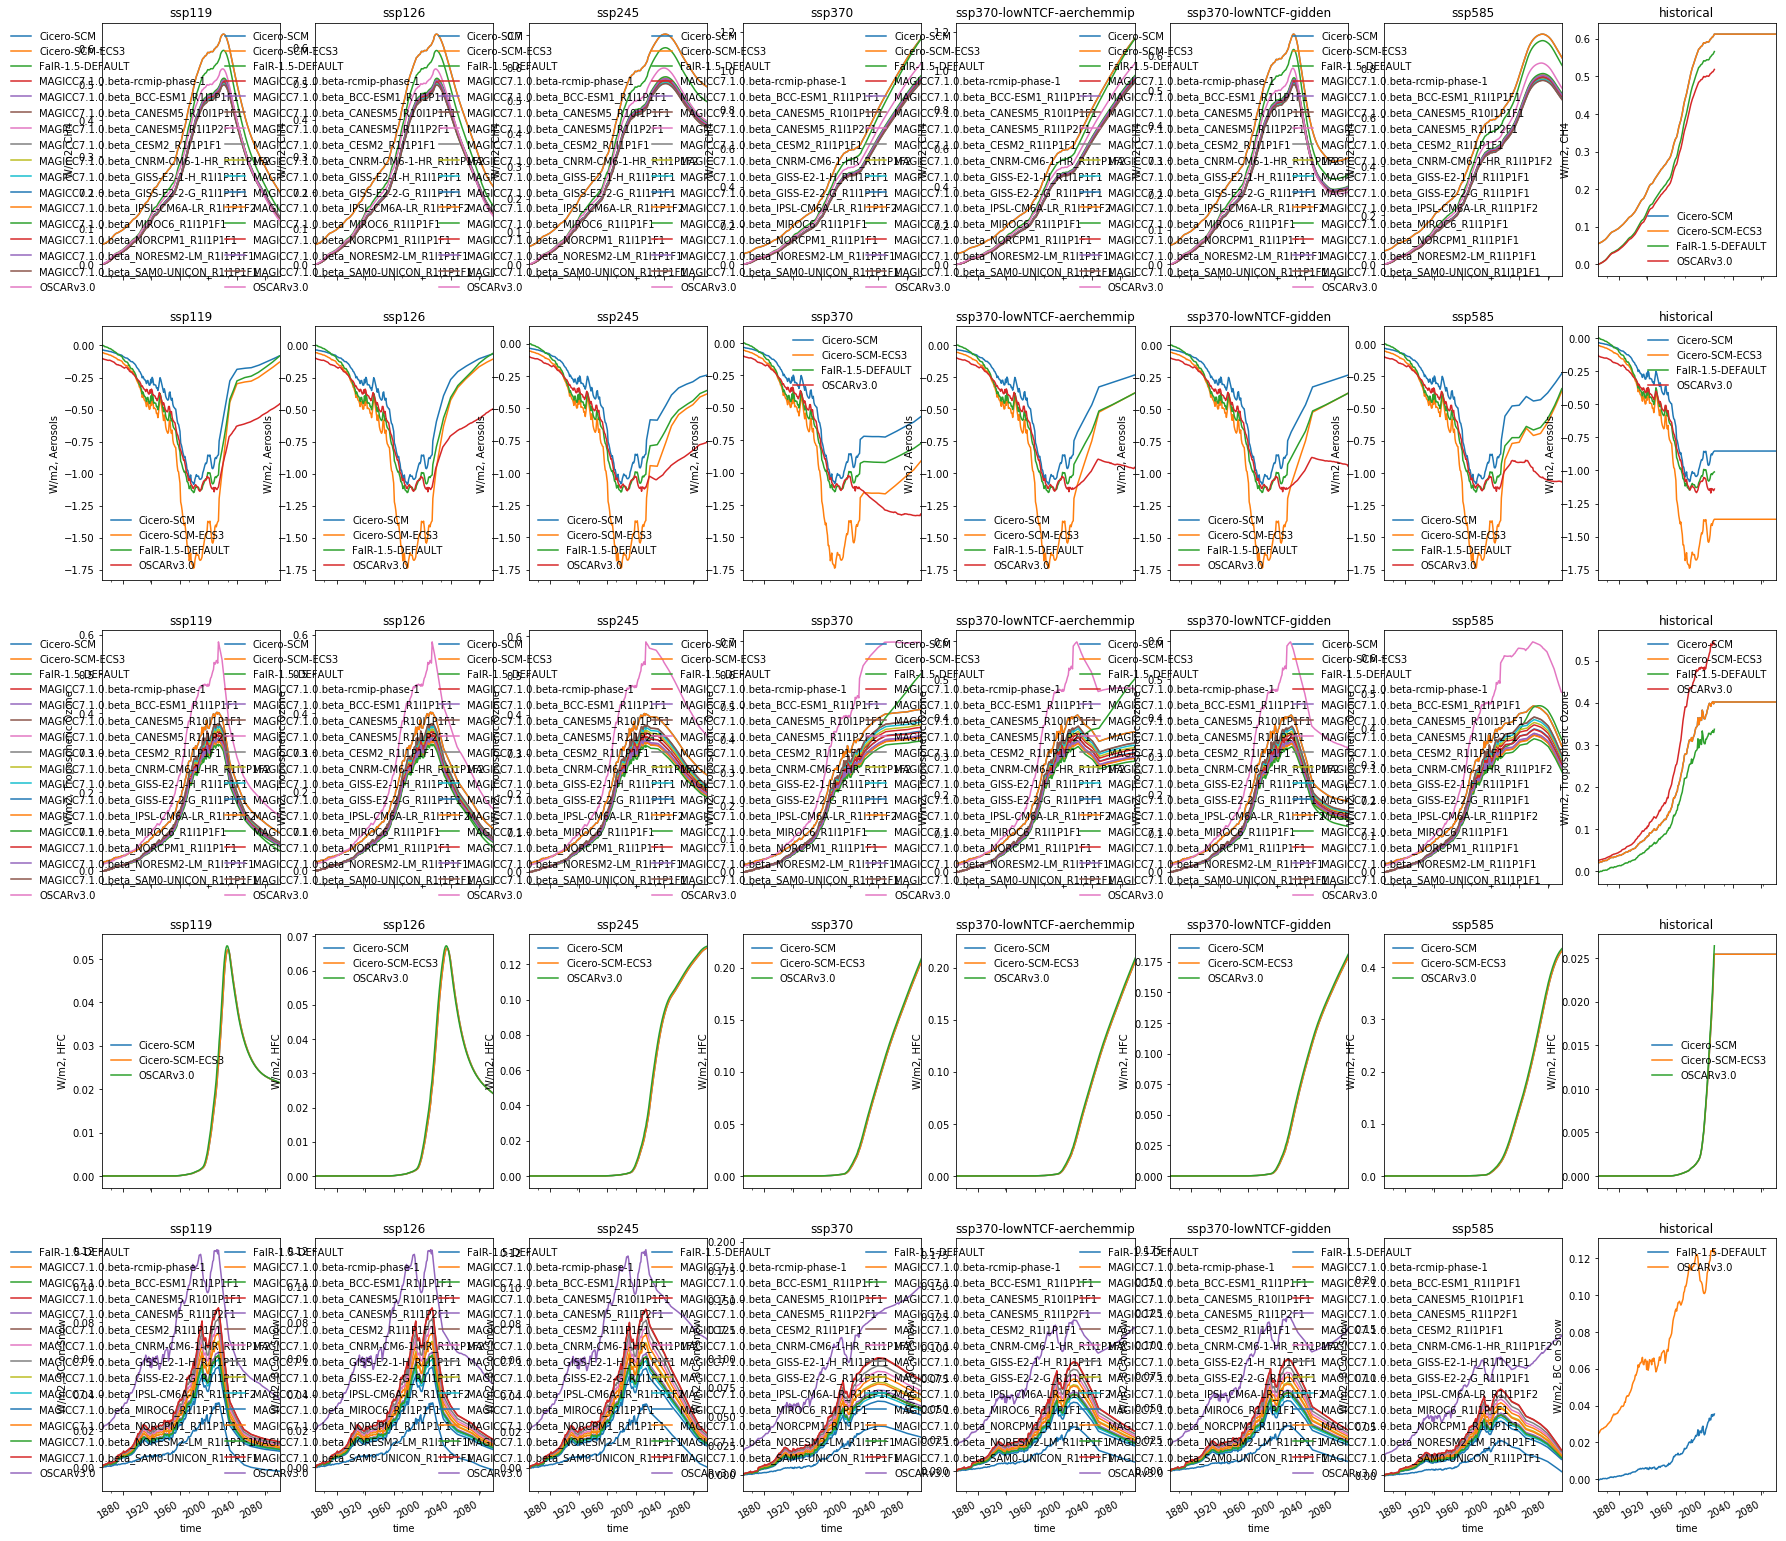

In [31]:
plot_available_out(db_aggregated, variables_erf_comp, scenarios_fl)

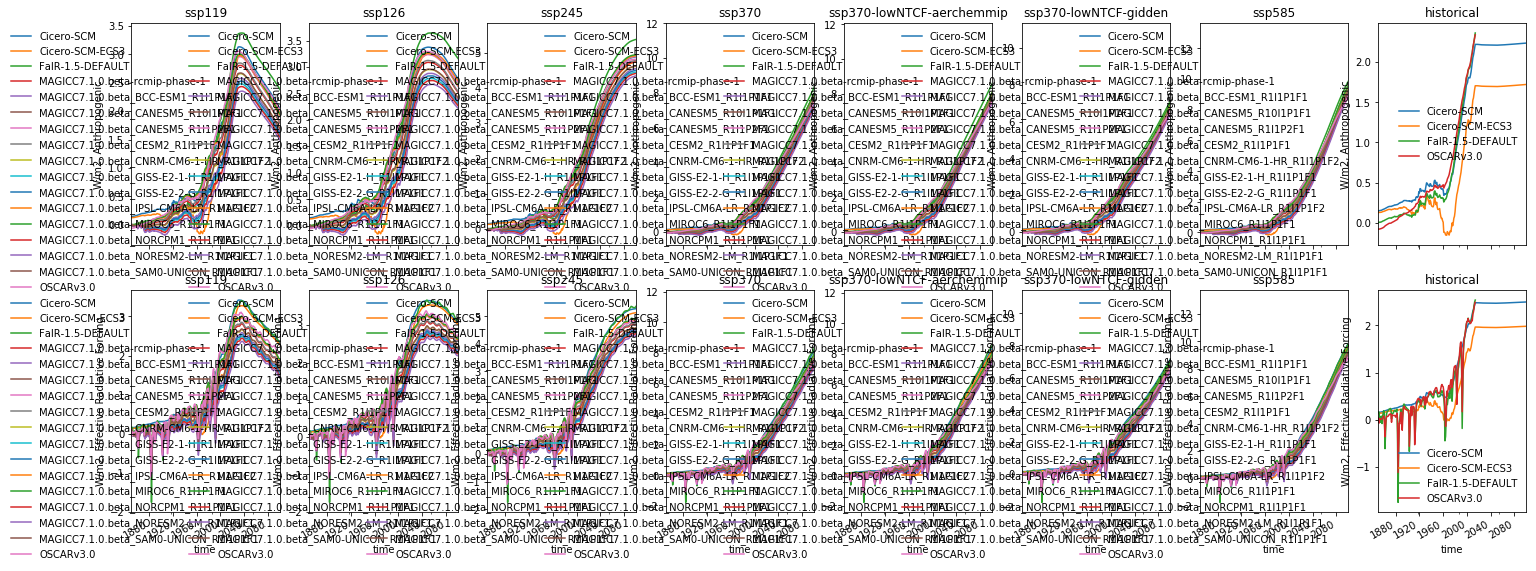

In [32]:
plot_available_out(db_aggregated, variables_erf_tot, scenarios_fl, figsize=[25, 10])

### Pick out the existing scenarios, models, forcings and times

In [33]:
print('Variables erf components:', variables_erf_comp)
print()
print('Variables erf totals:', variables_erf_tot)

Variables erf components: ['Effective Radiative Forcing|Anthropogenic|CH4', 'Effective Radiative Forcing|Anthropogenic|Aerosols', 'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone', 'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC', 'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']

Variables erf totals: ['Effective Radiative Forcing|Anthropogenic', 'Effective Radiative Forcing']


In [34]:
db_aggregated = db_aggregated#.filter(variable=variables_erf_comp + variables_erf_tot)

scenario = 'scenario'
climatemodel = 'climatemodel'
forcer = 'forcer'
time = 'time'
scenarios = list(db_aggregated[scenario].unique())  # scenarios_fl
climatemodels_fl = list(db_aggregated[climatemodel].unique())
forcings = list(db_aggregated[variable].unique())
times = db_aggregated.time_points  # timeseries().transpose().index

## Convert data to xarray dataset



In [45]:
import cftime

t_coord = db_aggregated.timeseries().transpose().index.values

ds = xr.Dataset()  # coords={time:t_coord, climatemodel:climatemodels_fl,
#      scenario:scenarios})
first = True
for var in db_aggregated[variable].unique():#variables_erf_comp + variables_erf_tot:
    # get data array for variable:
    _da = db_aggregated.filter(variable=var, climatemodel=climatemodels_fl
                               ).timeseries().transpose().unstack().to_xarray()#.squeeze()
    # convert to dataset:
    _ds = _da.to_dataset(name=var)
    #if 
    # remove coordinate for variabel (contained in name):
    del _ds.coords[variable]
    #if climatemodel not in _ds[var].coords:
    #    _ds[var].assign_coords({climatemodel:})
    # merge with existing dataset:
    ds = xr.merge([_ds, ds])
ds['year'] = xr.DataArray([t.year for t in ds['time'].values], dims='time')
ds['month'] = xr.DataArray([t.month for t in ds['time'].values], dims='time')
ds['day'] = xr.DataArray([t.day for t in ds['time'].values], dims='time')
# Convert to cftime
dates = [cftime.DatetimeGregorian(y, m, d) for y, m, d in zip(ds['year'], ds['month'], ds['day'])]
ds['time'] = dates
ds = ds.sel(time=slice('1850', '2100'))
ds['time'] = pd.to_datetime([pd.datetime(y, m, d) for y, m, d in zip(ds['year'], ds['month'], ds['day'])])
# Timestep for integral:
ds['delta_t'] = xr.DataArray(np.ones(len(ds['time'])), dims='time', coords={'time': ds['time']})
ds_save = ds.copy()

/home/sarambl/miniconda3/envs/rcmip_ipcc/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [46]:
ds

<xarray.Dataset>
Dimensions:                                                                                                                            (climatemodel: 18, model: 1, region: 1, scenario: 8, time: 251, unit: 1, unit_context: 1, variable: 1)
Coordinates:
  * time                                                                                                                               (time) datetime64[ns] 1850-01-01 ... 2100-01-01
  * climatemodel                                                                                                                       (climatemodel) object 'Cicero-SCM' ... 'OSCARv3.0'
  * model                                                                                                                              (model) object ''
  * scenario                                                                                                                           (scenario) object 'historical' ... 'ssp585'
  * region                                                                                                                             (region) object 'World'
  * unit                                                                                                                               (unit) object 'W/m^2'
  * unit_context                                                                                                                       (unit_context) object 'not_required'
Dimensions without coordinates: variable
Data variables:
    Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone|84th quantile                                                         (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... 0.6346
    Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone|16th quantile                                                         (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... 0.3686
    Effective Radiative Forcing|Anthropogenic|Stratospheric Ozone|84th quantile                                                        (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... 0.06788
    Effective Radiative Forcing|Anthropogenic|Stratospheric Ozone|16th quantile                                                        (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... -0.08323
    Effective Radiative Forcing|Anthropogenic|Other                                                                                    (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... 0.1166
    Effective Radiative Forcing|Anthropogenic|Montreal Gases|CFC                                                                       (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... 0.09181
    Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Land Cover Change|84th quantile                                      (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... 0.01304
    Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Land Cover Change|16th quantile                                      (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... -0.02296
    Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Land Cover Change                                                    (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... -0.004961
    Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Deposition of Black Carbon on Snow|84th quantile                     (model, scenario, region, variable, unit, climatemodel, unit_context, time) float64 nan ... 0.2577
    Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Deposition of Black Carbon on Snow|16th quantile                     (

In [49]:
ds_save.to_netcdf(SAVEPATH_DATASET)

In [39]:
SAVEPATH_DATASET

'/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_out/forcing_data_rcmip_models_quant.nc'